# Importy

In [6]:
from __future__ import division
import matplotlib as matplotlib
import sys
from pylab import *
import skimage as ski
import cv2
from skimage import data, io, filters, exposure, measure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from skimage.data import camera
from skimage.filters import frangi
from sklearn.metrics import accuracy_score
from matplotlib import pylab as plt
import numpy as np
from numpy import array
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from PIL import Image
from scipy import ndimage as ndi
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import cv2
import pandas as pd
import math
from skimage.transform import rescale
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
from skimage import filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/var/folders/5r/11qk23vn76gfnnsn277vd_4w0000gn/T/ipykernel_1449/2720367253.py:24: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


# Statystyka

In [11]:
def show_statistics(predicted, model):
    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0

    true_positive = np.sum((predicted > 0) & (model > 0))
    true_negative = np.sum((predicted == 0) & (model == 0))

    false_positive = np.sum((predicted > 0) & (model == 0))
    false_negative = np.sum((predicted == 0) & (model > 0))

    print(confusion_matrix(true_positive,true_negative,false_positive,false_negative))
    print()

    total = true_positive + true_negative + false_negative + false_positive
    
    accuracy = round((true_positive + true_negative) / (total), 4)
    sensitivity = round(true_positive / (true_positive + false_negative + 1), 4)
    specificity = round(true_negative / (false_positive + true_negative + 1), 4)
    precision = round(true_positive / (true_positive + false_positive + 1), 4)
    mean_sensitivity_specificity = round((sensitivity + specificity) / 2, 4)

    print("Accuracy: ", accuracy)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("Precision: ", precision)
    print("Mean Sensitivity-Specificity: ", mean_sensitivity_specificity)

In [12]:
def confusion_matrix(TP, TN, FP, FN):
    names = {
        'My Results' : ['Positive', 'Negative', 'Sum'],
        'Actually - Positive' : [TP, FN, TP + FN],
        'Actually - Negative' : [FP, TN, FP + TN],
        'Sum' : [TP + FP, FN + TN, TP + FP + FN + TN]
    }
    
    df = pd.DataFrame(names, columns=['My Results', 'Actually - Positive', 'Actually - Negative', 'Sum' ]).set_index('My Results')
    return df

# Filtr Frangi

In [13]:
def image_processing(image):
    # Wczytuje obraz z pliku .jpg
    img = cv2.imread('images/' + image + '.jpg')
    
    # Wybiera zielony kanał z obrazu (kanal G w formacie RGB)
    img_green = img[:, :, 1]

    # Stosuje filtr Frangi do zielonego kanału, który jest używany do wykrywania naczyń krwionośnych w obrazie
    img_frangi = frangi(img_green)

    # Przekształca wartości w obrazie filtrowanym Frangi do binarnej maski
    for i in range(len(img_frangi)):
        for j in range(len(img_frangi[i])):
            if img_frangi[i][j] > 0.0005:
                img_frangi[i][j] = 255
            else:
                img_frangi[i][j] = 0

    # Konwertuje oryginalny obraz do skali szarości
    img_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Tworzy binarną maskę z obrazu w skali szarości, gdzie piksele powyżej progu 1 są ustawione na 255 (biały), a poniżej na 0 (czarny)
    (thresh, blackAndWhiteImage) = cv2.threshold(img_mask, 1, 255, cv2.THRESH_BINARY)

    # Definiuje prosty kernel do operacji erozji
    kernel = np.ones((5, 5), np.uint8)
    
    # Stosuje erozję do binarnej maski, co pomaga usunąć drobne szumy
    blackAndWhiteImage = cv2.erode(blackAndWhiteImage, kernel)

    # Mnoży maskę frangi przez binarną maskę, aby uzyskać finalny obraz
    final = img_frangi * blackAndWhiteImage
    
    # Ponownie definiuje kernel do późniejszej operacji
    kernel = np.ones((5, 5), np.uint8)
    
    # Tworzy binarną maskę, gdzie wartości większe niż 0 są ustawione na True (białe), a reszta na False (czarne)
    x = final > 0
    
    # Usuwa małe obiekty
    end = mp.remove_small_objects(x, 5000)

    # Wczytuje obraz maski z pliku .tif i wybiera zielony kanał
    mask = cv2.cvtColor(cv2.imread('images/' + image + '.tif'), cv2.COLOR_BGR2RGB)[:, :, 1]

    # Wyświetla wczytaną maskę w kolorze RGB
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Wyświetla finalną maskę w skali szarości
    plt.imshow(end, cmap=cm.Greys_r)
    plt.show()

    # Wywołuje funkcję, która wyświetla statystyki porównujące finalną maskę z maską ekspercką
    show_statistics(end, mask)


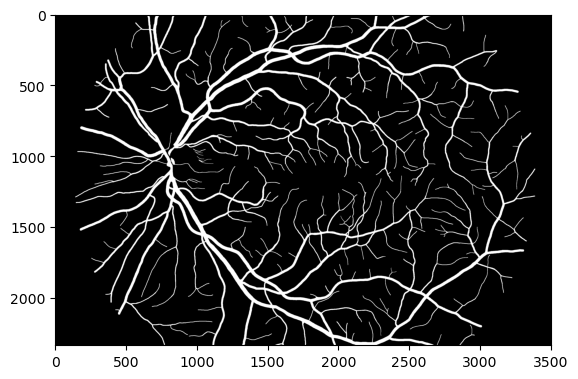

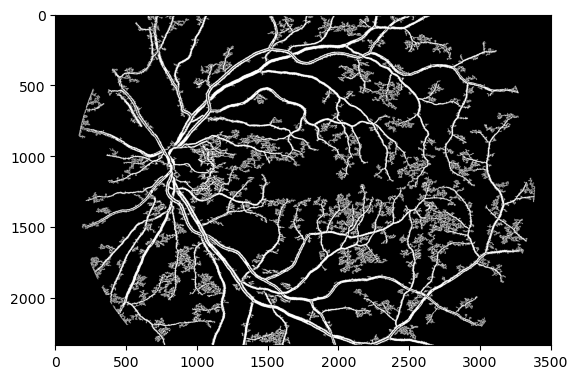

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 580956               442914  1023870
Negative                 240671              6920803  7161474
Sum                      821627              7363717  8185344

Accuracy:  0.9165
Sensitivity:  0.7071
Specificity:  0.9399
Precision:  0.5674
Mean Sensitivity-Specificity:  0.8235


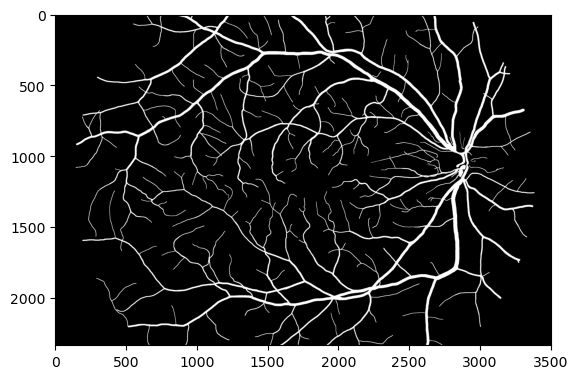

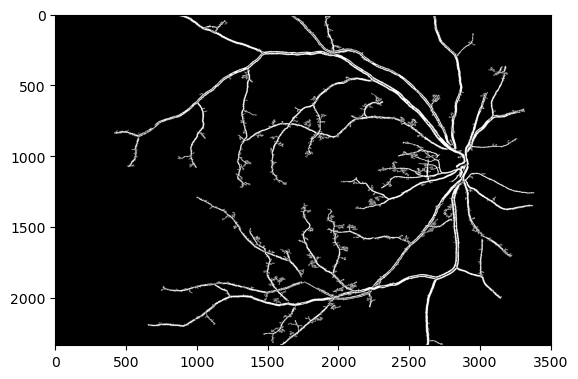

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 301221                69599   370820
Negative                 335247              7479277  7814524
Sum                      636468              7548876  8185344

Accuracy:  0.9505
Sensitivity:  0.4733
Specificity:  0.9908
Precision:  0.8123
Mean Sensitivity-Specificity:  0.732


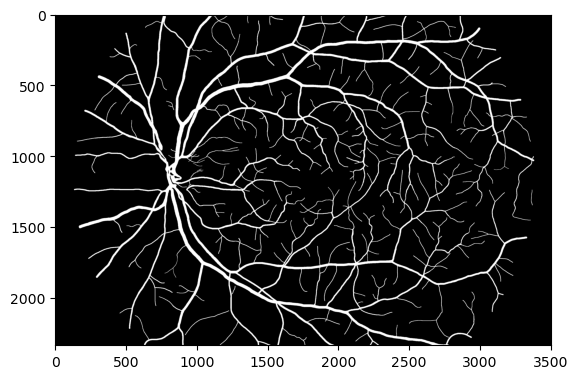

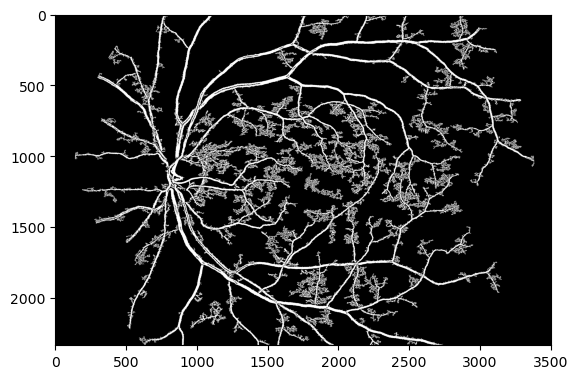

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 468746               381359   850105
Negative                 236692              7098547  7335239
Sum                      705438              7479906  8185344

Accuracy:  0.9245
Sensitivity:  0.6645
Specificity:  0.949
Precision:  0.5514
Mean Sensitivity-Specificity:  0.8068


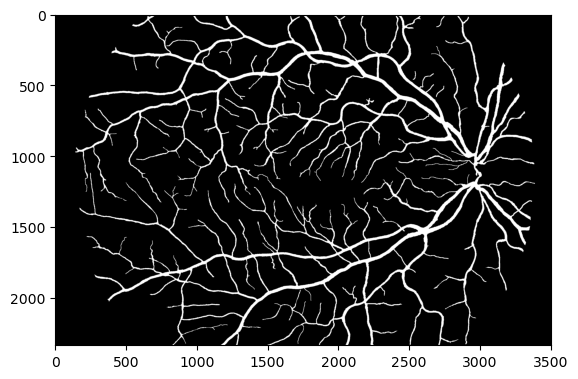

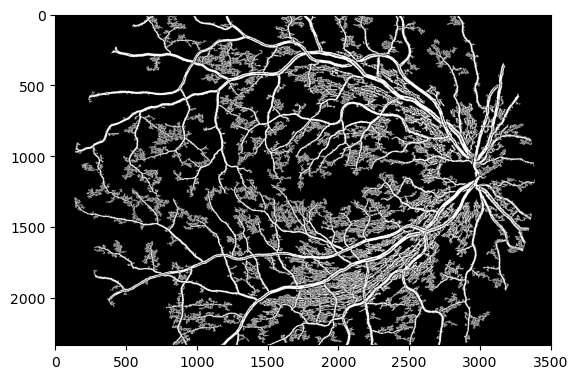

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 606585               759996  1366581
Negative                 158770              6659993  6818763
Sum                      765355              7419989  8185344

Accuracy:  0.8878
Sensitivity:  0.7926
Specificity:  0.8976
Precision:  0.4439
Mean Sensitivity-Specificity:  0.8451


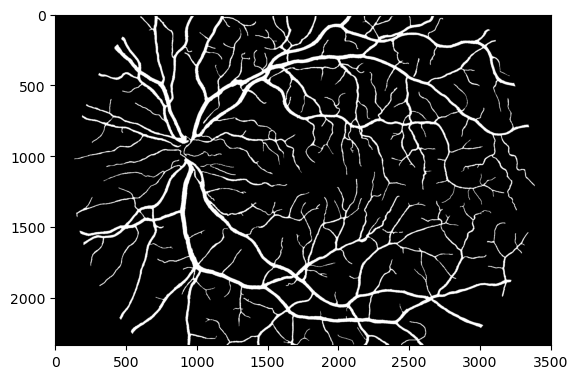

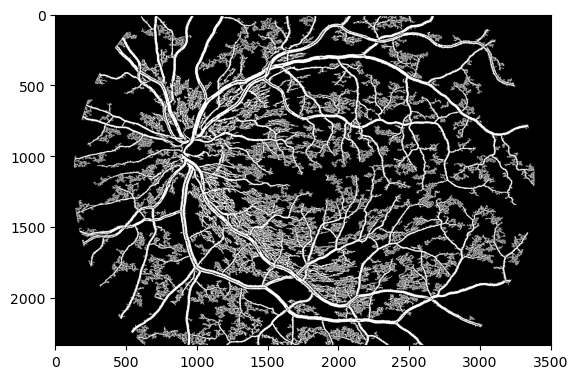

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 698853               827239  1526092
Negative                 160442              6498810  6659252
Sum                      859295              7326049  8185344

Accuracy:  0.8793
Sensitivity:  0.8133
Specificity:  0.8871
Precision:  0.4579
Mean Sensitivity-Specificity:  0.8502


In [14]:
image_processing('08_h')
image_processing('09_h')
image_processing('10_h')
image_processing('11_h')
image_processing('12_h')

# Las decyzyjny

In [11]:
SCALE = 0.5

def scaleImage(image):
    height, width = image.shape[:2]
    new_height = int(height * SCALE)
    new_width = int(width * SCALE)
    scaled_image = cv2.resize(image, (new_width, new_height))
    return scaled_image

In [1]:
PATCH_SIZE = 5  # Ustalony rozmiar fragmentu obrazu do analizy; mniejsze fragmenty mogą dostarczać bardziej szczegółowych informacji o lokalnych cechach obrazu

# Funkcja do ekstrakcji cech z obrazu
def get_features(image, gray):
    features = []  # Lista do przechowywania wektorów cech
    height, width = gray.shape  # Pobiera wysokość i szerokość obrazu w skali szarości

    # Przechodzi przez obraz, dzieląc go na małe fragmenty o rozmiarze PATCH_SIZE x PATCH_SIZE
    for y in range(0, height - PATCH_SIZE + 1):
        for x in range(0, width - PATCH_SIZE + 1):
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]  # Wybiera fragment obrazu
            patch_gray = gray[y:y + PATCH_SIZE, x:x + PATCH_SIZE]  # Odpowiedni fragment obrazu w skali szarości

            # Oblicza momenty dla fragmentu obrazu w skali szarości
            moments = cv2.moments(patch_gray)
            # Oblicza Hu-moments, które są niezmienne na obrót, skalowanie i translację
            hu_moments = cv2.HuMoments(moments).flatten()

            # Oblicza średnią i odchylenie standardowe dla każdego kanału kolorów w fragmencie obrazu
            # Te cechy pomagają scharakteryzować kolory i ich zmienność w analizowanym fragmencie
            mean = np.mean(patch.reshape(-1, 3), axis=0)
            std = np.std(patch.reshape(-1, 3), axis=0)
            
            # Tworzy wektor cech, łącząc średnią, odchylenie standardowe i hu_moments
            feature_vector = np.hstack([mean, std, hu_moments])
            features.append(feature_vector)  # Dodaje wektor cech do listy

    return features

# Funkcja do pobierania etykiet (wartości pikseli centralnych) dla każdego fragmentu obrazu
def get_labels(image):
    labels = []  # Lista do przechowywania etykiet
    height, width = image.shape  # Pobiera wysokość i szerokość obrazu

    # Przechodzi przez obraz i wybiera wartość piksela centralnego dla każdego fragmentu
    for y in range(0, height - PATCH_SIZE + 1):
        for x in range(0, width - PATCH_SIZE + 1):
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]  # Wybiera fragment obrazu
            label = patch[PATCH_SIZE // 2, PATCH_SIZE // 2]  # Wybiera wartość piksela centralnego fragmentu
            # Wybór piksela centralnego jest ważny, ponieważ reprezentuje on wartość dla całego fragmentu
            labels.append(label)  # Dodaje etykietę do listy

    return labels

# Funkcja do tworzenia obrazu z wartościami przewidywanymi przez model
def get_predicted_image(image, predicted):
    height, width = image.shape  # Pobiera wysokość i szerokość obrazu
    new_image = np.zeros((height, width))  # Tworzy nowy obraz o tych samych wymiarach, wypełniony zerami
    for y in range(0, height - PATCH_SIZE + 1):
        for x in range(0, width - PATCH_SIZE + 1):
            # Wstawia przewidywaną wartość do nowego obrazu
            # Używamy przewidywanej wartości dla całego fragmentu
            new_image[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = predicted[0]
            predicted = predicted[1:]  # Przechodzi do kolejnej przewidywanej wartości
    return new_image

In [20]:
features = []  # Lista do przechowywania cech z wszystkich obrazów treningowych
labels = []  # Lista do przechowywania etykiet z wszystkich obrazów treningowych

train_data = ["01", "02", "03"]  # Lista identyfikatorów obrazów treningowych

for train_image in train_data:
    print(f"Processing image: {train_image}")
    # Wczytuje obraz do analizy
    image = cv2.imread("images/" + train_image + "_h.jpg")
    # Skaluje obraz do odpowiedniego rozmiaru
    image = scaleImage(image)
    # Konwertuje obraz na skalę szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Stosuje filtr wyostrzający, który może poprawić widoczność drobnych szczegółów
    gray = filters.unsharp_mask(gray)

    # Wczytuje odpowiadający model obrazu (np. maska ekspercka)
    model = cv2.imread("images/" + train_image + "_h.tif")
    # Skaluje model do odpowiedniego rozmiaru
    model = scaleImage(model)
    # Konwertuje model do skali szarości
    model = cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)
    # Tworzy binarną maskę, gdzie piksele powyżej wartości 50 są ustawione na True
    model = model > 50
    print("Features and labels")
    # Dodaje cechy i etykiety do odpowiednich list
    features.extend(get_features(image, gray))
    labels.extend(get_labels(model))

Processing image: 01
Features and labels
Processing image: 02
Features and labels
Processing image: 03
Features and labels
Processing image: 04
Features and labels
Processing image: 05
Features and labels


In [21]:
features = np.array(features)  # Konwertuje listę cech na tablicę numpy
labels = np.array(labels)  # Konwertuje listę etykiet na tablicę numpy

print("Creating and fitting sampler")
# Tworzy i dopasowuje próbkę losową, aby zrównoważyć liczbę próbek w każdej klasie
sampler = RandomUnderSampler(sampling_strategy=1)
features, labels = sampler.fit_resample(features, labels)

print("Train test split")
# Dzieli dane na zestawy treningowe i testowe w celu oceny wydajności modelu
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
 
classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1)  # Inicjalizuje klasyfikator lasu losowego z 500 drzewami
print("Classifier fitting")
classifier.fit(X_train, y_train)  # Dopasowuje model do danych treningowych

print("Classifier scoring")
# Ocena wydajności klasyfikatora na danych testowych
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

dump(classifier, "test.joblib")  # Zapisuje wytrenowany klasyfikator do pliku "test.joblib"


Creating and fitiing sampler
Train test split
Classifier fitting
Classifier scoring
Accuracy: 0.901937398836933


['test2.joblib']

In [58]:
def load_classifier():
  return load("test.joblib")

loaded_classifier = load_classifier()


Processed image: 08


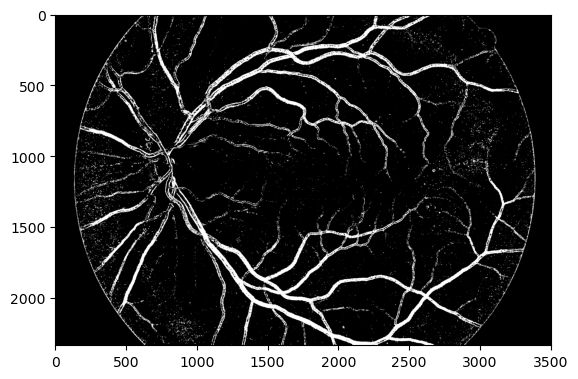

Expert image: 08


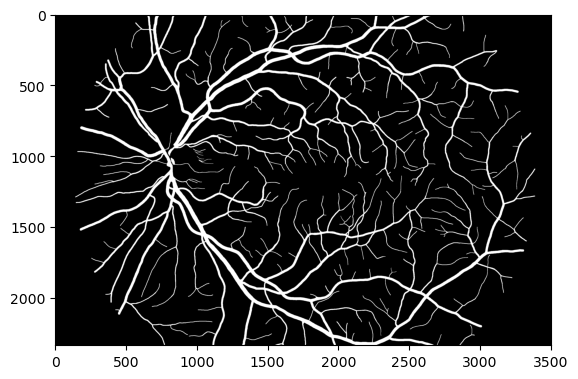

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 464057               233225   697282
Negative                 357570              7130492  7488062
Sum                      821627              7363717  8185344

Accuracy:  0.9278
Sensitivity:  0.5648
Specificity:  0.9683
Precision:  0.6655
Mean Sensitivity-Specificity:  0.7666

Processed image: 09


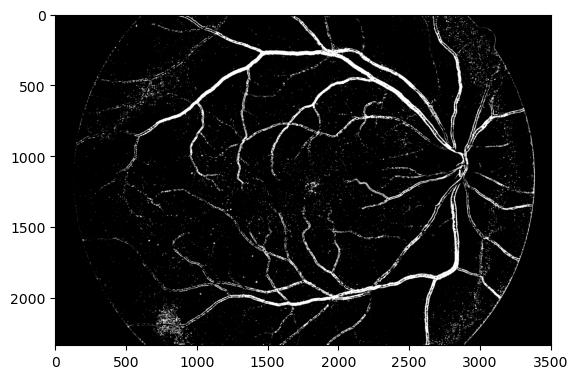

Expert image: 09


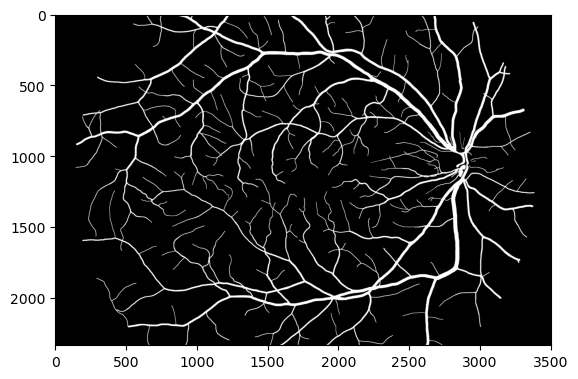

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 278973               180296   459269
Negative                 357495              7368580  7726075
Sum                      636468              7548876  8185344

Accuracy:  0.9343
Sensitivity:  0.4383
Specificity:  0.9761
Precision:  0.6074
Mean Sensitivity-Specificity:  0.7072

Processed image: 10


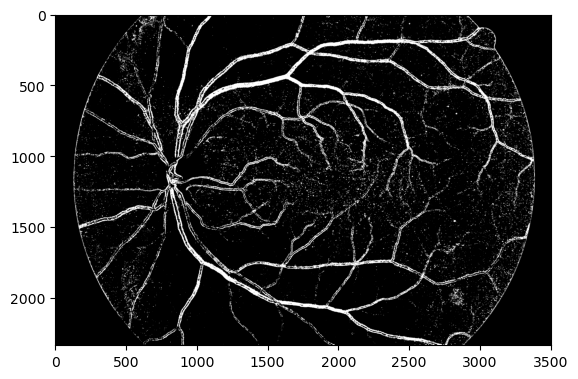

Expert image: 10


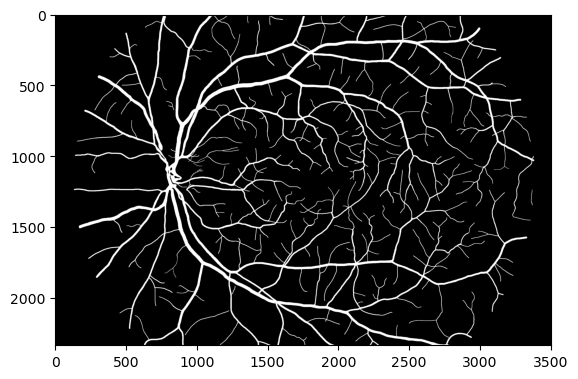

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 348529               295166   643695
Negative                 356909              7184740  7541649
Sum                      705438              7479906  8185344

Accuracy:  0.9203
Sensitivity:  0.4941
Specificity:  0.9605
Precision:  0.5414
Mean Sensitivity-Specificity:  0.7273

Processed image: 11


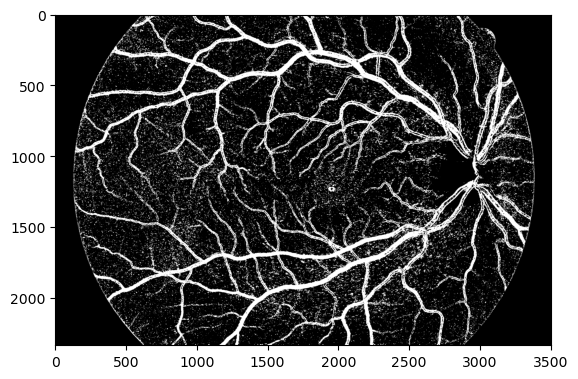

Expert image: 11


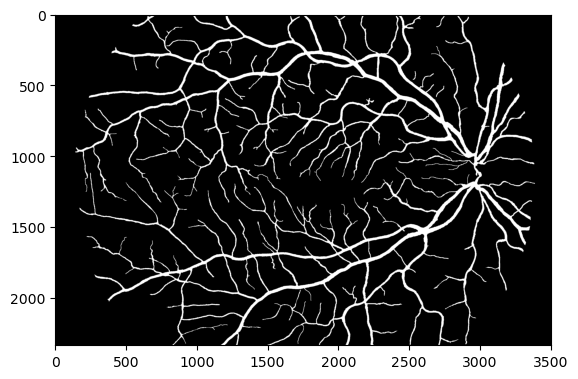

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 575123               782845  1357968
Negative                 190004              6637372  6827376
Sum                      765127              7420217  8185344

Accuracy:  0.8811
Sensitivity:  0.7517
Specificity:  0.8945
Precision:  0.4235
Mean Sensitivity-Specificity:  0.8231

Processed image: 12


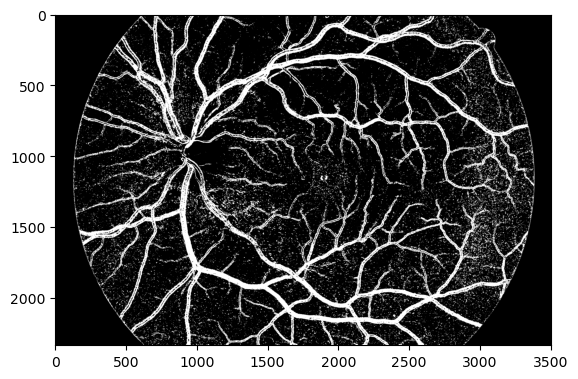

Expert image: 12


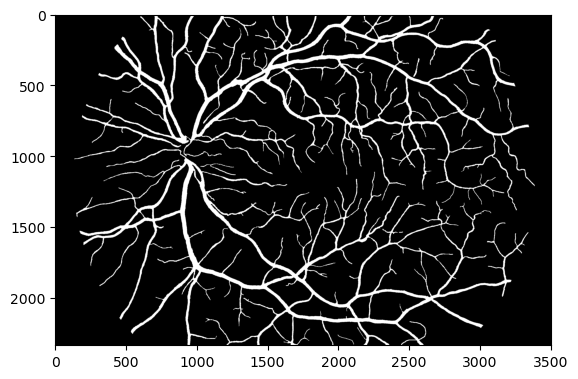

            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 642459               678284  1320743
Negative                 216198              6648403  6864601
Sum                      858657              7326687  8185344

Accuracy:  0.8907
Sensitivity:  0.7482
Specificity:  0.9074
Precision:  0.4864
Mean Sensitivity-Specificity:  0.8278


In [59]:
test_data = ["08","09","10","11","12"]


for train_image in test_data:
    image = cv2.imread("images/" + train_image + "_h.jpg")
    plt.imshow(image)
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = filters.unsharp_mask(gray)
    
    
    model = cv2.imread("images/" + train_image + "_h.tif")
    model = cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)
    model = model > 50
    
    classifier = loaded_classifier
    predictions = classifier.predict(get_features(image, gray))
    
    print()
    print(f"Processed image: {train_image}")
    predicted_image = get_predicted_image(gray, predictions)
    plt.imshow(predicted_image, cmap='gray')
    plt.show()
    print(f"Expert image: {train_image}")
    plt.imshow(model, cmap='gray')
    plt.show()
    
    
    show_statistics(predicted_image, model)

# Głęboka sieć neuronowa

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

PATCH_SIZE = 5  # Rozmiar fragmentu (patrz) wykorzystywanego do ekstrakcji cech

# Funkcja do ekstrakcji cech i etykiet z obrazu
def get_features_and_labels(image, gray, model):
    features = []
    labels = []
    height, width = gray.shape

    # Przechodzi przez obraz w krokach równych PATCH_SIZE
    for y in range(0, height - PATCH_SIZE + 1, PATCH_SIZE):
        for x in range(0, width - PATCH_SIZE + 1, PATCH_SIZE):
            # Wycinanie fragmentów obrazu
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_gray = gray[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            label_patch = model[y:y + PATCH_SIZE, x:x + PATCH_SIZE]

            # Oblicza momenty dla fragmentu w skali szarości
            moments = cv2.moments(patch_gray)
            hu_moments = cv2.HuMoments(moments).flatten()

            # Oblicza średnią i odchylenie standardowe dla każdego kanału kolorów
            mean = np.mean(patch.reshape(-1, 3), axis=0)
            std = np.std(patch.reshape(-1, 3), axis=0)
            
            # Tworzy wektor cech, łącząc średnią, odchylenie standardowe i momenty Hu
            feature_vector = np.hstack([mean, std, hu_moments])
            features.append(feature_vector)
            
            # Etykieta to wartość piksela centralnego
            label = label_patch[PATCH_SIZE // 2, PATCH_SIZE // 2]
            labels.append(label)

    return np.array(features), np.array(labels)

features = []
labels = []

# Lista nazw plików obrazów treningowych
train_data = ["01", "02", "03", "04", "05", "06", "07"]

for train_image in train_data:
    print(f"Processing image: {train_image}")
    image = cv2.imread("images/" + train_image + "_h.jpg")
    image = scaleImage(image)  # Skaluje obraz do odpowiedniego rozmiaru

    # Konwersja do skali szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = filters.unsharp_mask(gray)  # Zastosowanie maski wyostrzającej

    model = cv2.imread("images/" + train_image + "_h.tif")
    model = scaleImage(model)  # Skaluje obraz maski do odpowiedniego rozmiaru
    
    model = cv2.cvtColor(model, cv2.COLOR_BGR2GRAY)  # Konwersja do skali szarości
    model = model > 25  # Próg binarny do stworzenia maski binarnej

    print("Extracting features and labels")
    feats, lbls = get_features_and_labels(image, gray, model)  # Ekstrakcja cech i etykiet
    features.extend(feats)
    labels.extend(lbls)

features = np.array(features)
labels = np.array(labels)

print("Balancing data")
# Balansowanie danych za pomocą losowego próbkowania
sampler = RandomUnderSampler(sampling_strategy=1)
features, labels = sampler.fit_resample(features, labels)

print("Splitting data")
# Dzieli dane na zestawy treningowe i testowe w proporcji 80/20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Konwertuje etykiety na postać kategoryczną (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Definicja modelu sekwencyjnego
model = Sequential([
    Dense(64, activation='relu', input_shape=(features.shape[1],)),  # Warstwa wejściowa z 64 neuronami
    Dense(128, activation='relu'),  # Warstwa ukryta z 128 neuronami
    Dense(64, activation='relu'),   # Kolejna warstwa ukryta z 64 neuronami
    Dense(2, activation='softmax')  # Warstwa wyjściowa z 2 neuronami dla klasyfikacji binarnej
])

# Kompilacja modelu z użyciem optymalizatora Adam, funkcji straty kategorii i metryki dokładności, 
#Funkcja straty kategorii została wybrana, ponieważ mamy do czynienia z problemem klasyfikacji binarnej i wyjście modelu jest kodowane w postaci kategorialnej
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training model")
# Trening modelu przez 100 epok, z rozmiarem batcha 5 i 20% danymi walidacyjnymi
model.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.2)

print("Evaluating model")
# Ocena modelu na danych testowych
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

model.save("newmodel.h5")  # Zapisuje wytrenowany model do pliku "newmodel.h5"


Processing image: 01
Extracting features and labels
Processing image: 02
Extracting features and labels
Processing image: 03
Extracting features and labels
Processing image: 04
Extracting features and labels
Processing image: 05
Extracting features and labels
Processing image: 06
Extracting features and labels
Processing image: 07
Extracting features and labels
Balancing data
Splitting data
Training model
Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 445us/step - accuracy: 0.7922 - loss: 27.8201 - val_accuracy: 0.8598 - val_loss: 0.3401
Epoch 2/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 432us/step - accuracy: 0.8528 - loss: 0.5048 - val_accuracy: 0.8572 - val_loss: 0.3433
Epoch 3/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 428us/step - accuracy: 0.8529 - loss: 0.3507 - val_accuracy: 0.8478 - val_loss: 0.3503
Epoch 4/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 427us/step - accuracy: 0.8585 - loss: 1102.9467 - val_accuracy: 0.8624 - val_loss: 0.3338
Epoch 5/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 429us/step - accuracy: 0.8599 - loss: 0.3379 - val_accuracy: 0.8529 - val_loss: 0.3513
Epoch 6/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 436us/step - accuracy: 0.8590 - loss: 0.3392 - val_accuracy: 0.8596 - val_loss: 0.3351
Epoch 7/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 432us/step - accuracy: 0.8617 - loss: 0.3396 - val_accuracy: 0.8616 - val_loss: 0.3375
Epoch 8/100
15852/15852 ━━━━━━━━━━━━━━━━━━━━ 7s 437us/step - ac

Accuracy: 0.8618378639221191


In [36]:
def get_predicted_image(gray, predictions, patch_size):
    predicted_image = np.zeros_like(gray)
    height, width = gray.shape
    index = 0

    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            predicted_image[y:y + patch_size, x:x + patch_size] = predictions[index]
            index += 1

    return predicted_image

Processing image: 08
Extracting features for prediction
Making predictions
10216/10216 ━━━━━━━━━━━━━━━━━━━━ 3s 251us/step
Predicted image:


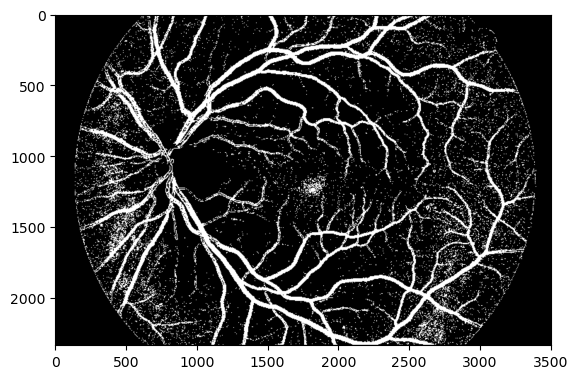

Ground truth image:


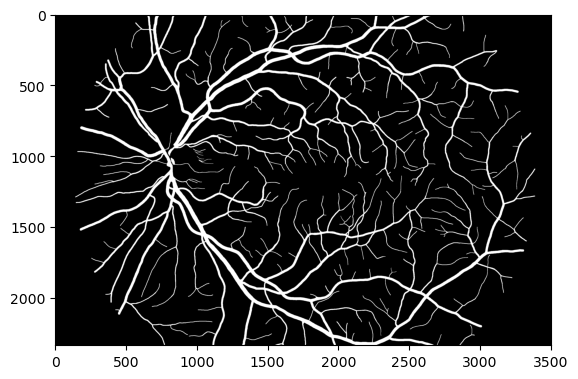

Statistics:
            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 646359               621641  1268000
Negative                 175268              6742076  6917344
Sum                      821627              7363717  8185344

Accuracy:  0.9026
Sensitivity:  0.7867
Specificity:  0.9156
Precision:  0.5097
Mean Sensitivity-Specificity:  0.8512
Processing image: 09
Extracting features for prediction
Making predictions
10216/10216 ━━━━━━━━━━━━━━━━━━━━ 3s 261us/step
Predicted image:


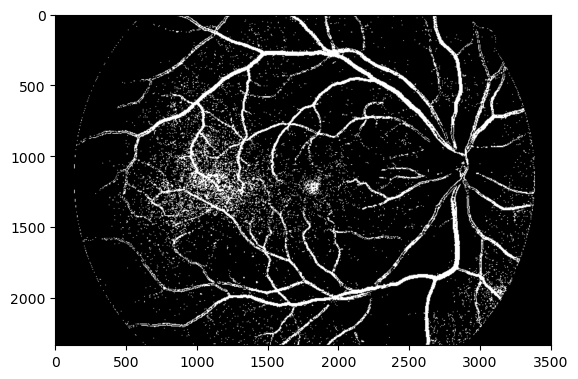

Ground truth image:


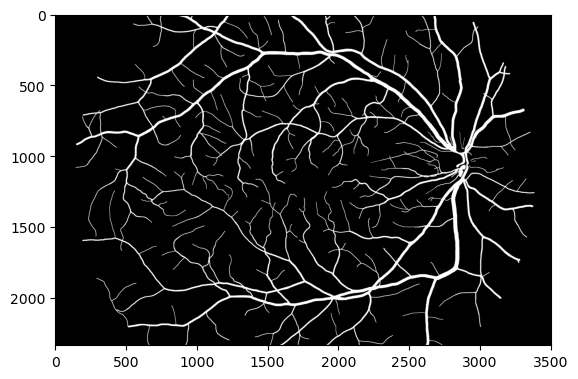

Statistics:
            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 405824               402426   808250
Negative                 230644              7146450  7377094
Sum                      636468              7548876  8185344

Accuracy:  0.9227
Sensitivity:  0.6376
Specificity:  0.9467
Precision:  0.5021
Mean Sensitivity-Specificity:  0.7921
Processing image: 10
Extracting features for prediction
Making predictions
10216/10216 ━━━━━━━━━━━━━━━━━━━━ 3s 255us/step
Predicted image:


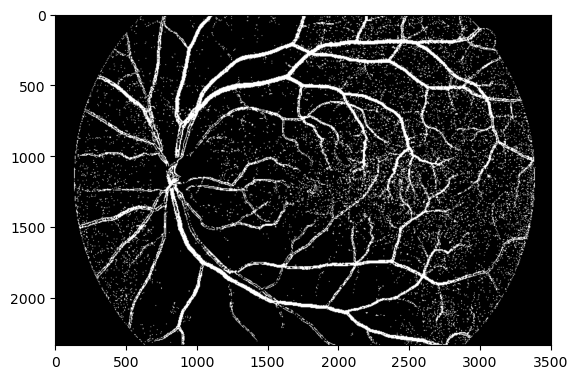

Ground truth image:


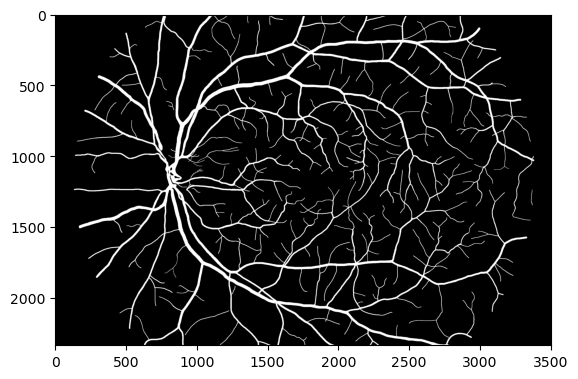

Statistics:
            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 461246               504379   965625
Negative                 244192              6975527  7219719
Sum                      705438              7479906  8185344

Accuracy:  0.9085
Sensitivity:  0.6538
Specificity:  0.9326
Precision:  0.4777
Mean Sensitivity-Specificity:  0.7932
Processing image: 11
Extracting features for prediction
Making predictions
10216/10216 ━━━━━━━━━━━━━━━━━━━━ 3s 252us/step
Predicted image:


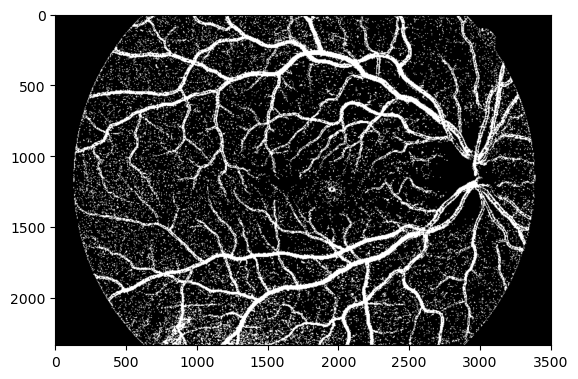

Ground truth image:


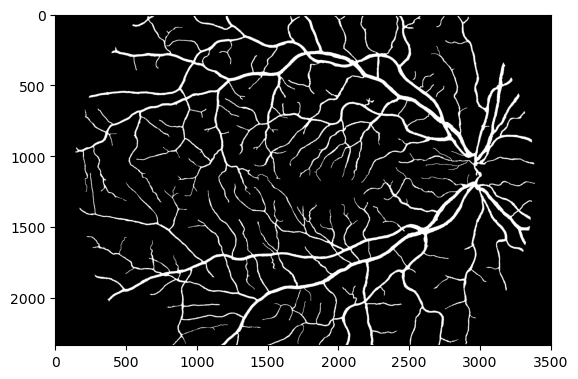

Statistics:
            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 594674               880776  1475450
Negative                 170509              6539385  6709894
Sum                      765183              7420161  8185344

Accuracy:  0.8716
Sensitivity:  0.7772
Specificity:  0.8813
Precision:  0.403
Mean Sensitivity-Specificity:  0.8292
Processing image: 12
Extracting features for prediction
Making predictions
10216/10216 ━━━━━━━━━━━━━━━━━━━━ 3s 260us/step
Predicted image:


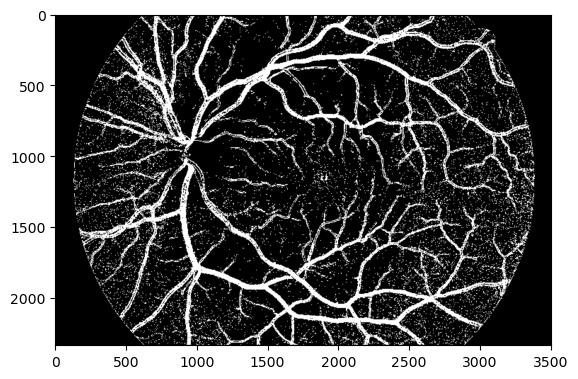

Ground truth image:


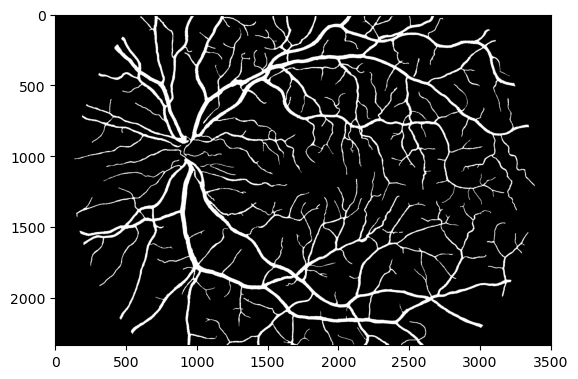

Statistics:
            Actually - Positive  Actually - Negative      Sum
My Results                                                   
Positive                 660176               683824  1344000
Negative                 198649              6642695  6841344
Sum                      858825              7326519  8185344

Accuracy:  0.8922
Sensitivity:  0.7687
Specificity:  0.9067
Precision:  0.4912
Mean Sensitivity-Specificity:  0.8377


In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage import filters
from tensorflow.keras.utils import to_categorical

model = load_model("newmodel.h5")

test_data = ["08","09","10", "11", "12"]

for test_image in test_data:
    print(f"Processing image: {test_image}")
    image = cv2.imread("images/" + test_image + "_h.jpg")


    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = filters.unsharp_mask(gray)
    
    ground_truth = cv2.imread("images/" + test_image + "_h.tif")
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    ground_truth = ground_truth > 25

    print("Extracting features for prediction")
    features, _ = get_features_and_labels(image, gray, ground_truth)
    
    print("Making predictions")
    predictions = model.predict(features)
    predictions = np.argmax(predictions, axis=1)
    
    predicted_image = get_predicted_image(gray, predictions.reshape(-1, 1), PATCH_SIZE)
    
    print("Predicted image:")
    plt.imshow(predicted_image, cmap='gray')
    plt.show()

    print("Ground truth image:")
    plt.imshow(ground_truth, cmap='gray')
    plt.show()

    print("Statistics:")
    show_statistics(predicted_image, ground_truth)

# Porównanie wyników

## zdjęcie nr 8

### Frangi:

Accuracy:  0.9165

Sensitivity:  0.7071

Specificity:  0.9399

Precision:  0.5674

Mean Sensitivity-Specificity:  0.8235


### Las decyzyjny:

Accuracy:  0.9278

Sensitivity:  0.5648

Specificity:  0.9683

Precision:  0.6655

Mean Sensitivity-Specificity:  0.7666

### Sieć neuronowa:

Accuracy:  0.9026

Sensitivity:  0.7867

Specificity:  0.9156

Precision:  0.5097

Mean Sensitivity-Specificity:  0.8512

## zdjęcie nr 9

### Frangi:

Accuracy:  0.9505

Sensitivity:  0.4733

Specificity:  0.9908

Precision:  0.8123

Mean Sensitivity-Specificity:  0.732

### Las decyzyjny:

Accuracy:  0.9343

Sensitivity:  0.4383

Specificity:  0.9761

Precision:  0.6074

Mean Sensitivity-Specificity:  0.7072

### Sieć neuronowa:

Accuracy:  0.9227

Sensitivity:  0.6376

Specificity:  0.9467

Precision:  0.5021

Mean Sensitivity-Specificity:  0.7921

## zdjęcie nr 10

### Frangi:
Accuracy: 0.8878

Sensitivity: 0.7926

Specificity: 0.8976

Precision: 0.4439

Mean Sensitivity-Specificity: 0.8451

### Las decyzyjny:

Accuracy:  0.8811

Sensitivity:  0.7517

Specificity:  0.8945

Precision:  0.4235

Mean Sensitivity-Specificity:  0.8231

### Sieć neuronowa:

Accuracy:  0.9085

Sensitivity:  0.6538

Specificity:  0.9326

Precision:  0.4777

Mean Sensitivity-Specificity:  0.7932

## zdjęcie nr 11

### Frangi:

Accuracy:  0.9245

Sensitivity:  0.6645

Specificity:  0.949

Precision:  0.5514

Mean Sensitivity-Specificity:  0.8068


### Las decyzyjny:

Accuracy:  0.8811

Sensitivity:  0.7517

Specificity:  0.8945

Precision:  0.4235

Mean Sensitivity-Specificity:  0.8231

### Sieć neuronowa:

Accuracy:  0.8716

Sensitivity:  0.7772

Specificity:  0.8813

Precision:  0.403

Mean Sensitivity-Specificity:  0.8292

## zdjęcie nr 12

### Frangi

Accuracy: 0.8793

Sensitivity: 0.8133

Specificity: 0.8871

Precision: 0.4579

Mean Sensitivity-Specificity: 0.8502

### Las decyzyjny:

Accuracy:  0.8907

Sensitivity:  0.7482

Specificity:  0.9074

Precision:  0.4864

Mean Sensitivity-Specificity:  0.8278

### Sieć neuronowa:

Accuracy:  0.8922

Sensitivity:  0.7687

Specificity:  0.9067

Precision:  0.4912

Mean Sensitivity-Specificity:  0.8377

## Podsumowanie:
Metoda z wykorzystaniem filtru Frangi - wykazuje dobrą równowagę między czułością i swoistością, ale jest mniej precyzyjna niż sieć neuronowa, co sugeruje większą liczbę fałszywych pozytywów. Wyniki wskazują na wysoką dokładność, co oznacza, że metoda ta jest efektywna w klasyfikacji obrazów i minimalizacji błędów ogólnych. Wymaga ręcznego dostosowania.

Las Decyzyjny - ogólnie charakteryzuje się wyższą dokładnością i swoistością niż sieć neuronowa, ale niższą czułością. Oznacza to, że lepiej identyfikuje negatywne przypadki, ale ma trudności z identyfikacją pozytywnych przypadków.
    
Sieć Neuronowa - ogólnie charakteryzuje się wyższą czułością i średnią wartością czułości i swoistości, co wskazuje na lepszą równowagę między wykrywaniem pozytywnych i negatywnych przypadków. Dokładność i swoistość są zazwyczaj nieco niższe niż w przypadku lasu decyzyjnego, ale czułość jest wyraźnie wyższa. Wizualnie lepiej przypomina maskę ekspercką niż las decyzyjny.